## Imports and helper functions

In [1]:
import transformers
import diffusers

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers import (
    AutoencoderKL,
    T2IAdapter,
    MultiAdapter,
    StableDiffusionAdapterPipeline,
    DDPMScheduler
)

import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers.optimization import get_scheduler

/n/home07/adamaraju/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

In [3]:
#Thing to do for tomorrow, create a new learning rate that mimics the one from the t2i paper

In [4]:
from types import SimpleNamespace
from datasets import load_dataset

#Generate an arg list 

args = SimpleNamespace()

#Dataset generation args
args.dataset_name = "Double GPU tests"#"fusing/fill50k"
args.train_data_dir = None #"../ControlNet/training/fill50k"
args.dataset_config_name=None
args.cache_dir = None
args.image_column = "image"
args.caption_column = "text"
args.conditioning_image_column = "conditioning_image"
args.resolution = 512
args.max_train_samples = 1000
args.seed = None
args.train_batch_size = 4
args.dataloader_num_workers = 0

#Training args
args.num_train_epochs = 10
args.max_train_steps = 1000
args.gradient_accumulation_steps = 1
args.do_classifier_free_guidance= False
args.validation_steps = 1
args.set_grads_to_none = False
#learning rate
args.lr = 1e-5
args.lr_scheduler = "constant"
args.lr_num_cycles = 1
args.lr_power = 1
args.lr_warmup_steps = 10

#Validation args
args.seed = None

#adapter args
args.adapter_conditioning_scale = 1.0
args.num_images_per_prompt = 1

## Generate training dataset

### Generate base images first

(-0.5, 511.5, 511.5, -0.5)

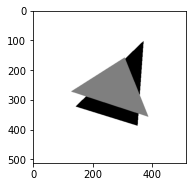

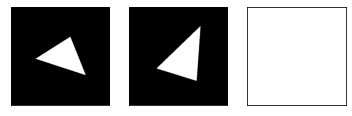

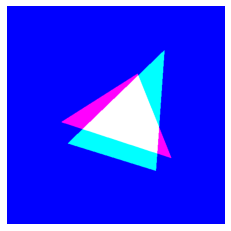

In [5]:
#Generate some generic training data real quick


import numpy as np 
import cv2
import matplotlib.pyplot as plt

def generate_triangle_sdf(H,W):
    EPS = 1e-12
    x_pos, y_pos = np.meshgrid(np.linspace(0, (H-1), H),np.linspace(0, (W-1), W))

    thresh = int(.2*W)
    len_thresh = thresh*2
    img_np = np.zeros((H, W), dtype=np.uint8)
    valid2 = False
    valid3 = False
    while valid2 == False or valid3 == False:
        x_1 = int(np.random.uniform(thresh,H-thresh))
        y_1 = int(np.random.uniform(thresh,W-thresh))

        #Compute a second point for the triangle
        x_2 = int(np.random.uniform(thresh,H-thresh))
        y_2 = int(np.random.uniform(thresh,W-thresh))
        idx = 0 
        while np.linalg.norm(np.array([x_1,y_1]) - np.array([x_2,y_2])) < len_thresh:
            if idx < 50:
                x_2 = int(np.random.uniform(thresh,H-thresh))
                y_2 = int(np.random.uniform(thresh,W-thresh))
                valid2 = True
            else:
                valid2 = False
                break

        x_3 = int(np.random.uniform(thresh,H-thresh))
        y_3 = int(np.random.uniform(thresh,W-thresh))
        idx = 0
        while (np.linalg.norm(np.array([x_1,y_1]) - np.array([x_3,y_3])) < len_thresh) or (np.linalg.norm(np.array([x_2,y_2]) - np.array([x_3,y_3])) < len_thresh):
            idx = idx +1
            if idx < 50:
                x_3 = int(np.random.uniform(thresh,H-thresh))
                y_3 = int(np.random.uniform(thresh,W-thresh)) 
                valid3 = True
            else:
                valid3 = False
                break
    
    pts_inp = np.array([[x_1, y_1], [x_2, y_2], [x_3, y_3]])
    
    oop_normal = [0,0,1]
    
    n = np.cross([x_1-x_2,y_1-y_2,0], [x_3-x_2,y_3-y_2])
    
    if np.dot(n,oop_normal) < 0:
        pts_inp = pts_inp[[0,2,1],:]
        x_2,y_2 = pts_inp[1,:]
        x_3,y_3 = pts_inp[2,:]
        
    normals = []
    ix_12 = np.linspace(x_1,x_2,500)
    m_12 = (y_2-y_1)/(x_2-x_1 + EPS)
    iy_12 = y_2 + m_12*(ix_12 - x_2)
    out_12 =  np.array([[x, y] for (x, y) in zip(ix_12, iy_12)])
    norm_12 = [np.arctan2(y_2-y_1, x_2-x_1)+np.pi/2] * len(ix_12)
    normals.extend(norm_12)
    
    ix_23 = np.linspace(x_2,x_3,500)
    m_23 = (y_3-y_2)/(x_3-x_2 + EPS)
    iy_23 = y_3 + m_23*(ix_23 - x_3)
    out_23 =  np.array([[x, y] for (x, y) in zip(ix_23, iy_23)])
    norm_23 = [np.arctan2(y_3-y_2, x_3-x_2)+np.pi/2] * len(ix_23)
    normals.extend(norm_23)
    
    ix_31 = np.linspace(x_3,x_1,500)
    m_31 = (y_1-y_3)/(x_1-x_3 + EPS)
    iy_31 = y_1 + m_31*(ix_31 - x_1)
    out_31 =  np.array([[x, y] for (x, y) in zip(ix_31, iy_31)])
    norm_31 = [np.arctan2(y_1-y_3, x_1-x_3)+np.pi/2] * len(ix_31)
    normals.extend(norm_31)
    
    #Combine all 3 ouputs
    out_pts = np.concatenate([out_12,out_23,out_31],axis=0)
    out_pts = out_pts.reshape((1, -1, 2))

    
    pts = pts_inp.reshape((1,-1,2))
    cv2.fillPoly(img_np, pts, color=255, lineType=cv2.LINE_AA)
    img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
    img = np.asarray(img/255.0,dtype=np.float32)
    img = np.asarray(img>.5,dtype=np.float32)
    normals = np.asarray(normals)
    
    return img, out_pts, normals

H=W=512

img,out_pts,normals = generate_triangle_sdf(H,W)
img = 1- img
first_img = (np.repeat(img,3,-1)* 255).astype(np.uint8)
plt.imshow(first_img)

mask_img,_,_ = generate_triangle_sdf(H,W)
mask_img = mask_img[:,:,0].astype(int)


masked_img = np.copy(img)
masked_img[mask_img==1] = .5


plt.subplot(122)
plt.imshow((np.repeat(masked_img,3,-1)* 255).astype(np.uint8),cmap='gray_r')

plt.figure()
plt.subplot(131)
fg_layer = mask_img
plt.imshow(fg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);

plt.subplot(132)
mid_layer = (1-img).squeeze()
plt.imshow(mid_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);

plt.subplot(133)
bg_layer = np.ones(mid_layer.shape)
plt.imshow(bg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);

plt.figure()
layer_img = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)
plt.imshow(layer_img)
plt.axis('off')

In [6]:
DATASET_SIZE=1000
H=W=512

layer_binaries = []
layer_imgs = []
base_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(DATASET_SIZE):
    img,_,_ = generate_triangle_sdf(H,W)
    img = 1- img
    
    #Mask (foreground layer)
    mask_img,_,_ = generate_triangle_sdf(H,W)
    mask_img = mask_img[:,:,0].astype(int)

    #Plain background layer
    bg_layer = np.ones([H,W])
    
    #Compositing full image
    masked_img = np.copy(img)
    masked_img[mask_img==1] = .5
    
    #Compositing layer map
    fg_layer = mask_img
    mid_layer = (1-img).squeeze()
    layer_bin = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)

    #add to lists
    layer_binaries.append(layer_bin)
    layer_imgs.append((gray2rgb(1-fg_layer[...,np.newaxis]*.5),
                       gray2rgb(1-mid_layer[...,np.newaxis]),
                       gray2rgb(bg_layer[...,np.newaxis])))
    base_imgs.append(gray2rgb(masked_img))
    
    if itr%200 == 0:
        print(itr)
    

0
200
400
600
800


In [7]:
# # Also need to generate some utils for the training for the layering maps
# # For example need some code that combines all layer maps below a layer and all above a layer
# # Also need analagous code that does this for the layered  objects in the image

# def get_front_layers(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) -1 #subtract 1 for loops??
#     front_layers = np.ones(layer_imgs[0].shape)
#     front_bin = np.zeros(layer_bin.shape)
#     if layer_no == num_layers:
#         return front_layers,front_bin
#     else:
#         for layer_idx in range(layer_no,num_layers):
#             front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#             front_bin[layer_bin==1] = 1
#         return front_layers,front_bin
        

# def get_back_layer(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) - 1
#     back_layers = np.ones(layer_imgs[0].shape)
#     back_bin = np.zeros(layer_bin.shape)
#     for layer_idx in range(layer_no):
#         #FINISH / FIX THIS CODE AT SOMEPOINT
#         front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#         front_bin[layer_bin==1] = 1
#     return front_layers,front_bin

### Put data into dataset objects

In [8]:
#Define image transforms

image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

conditioning_image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
    ]
)

In [9]:
# Create a dataset class
class LayerDataset(Dataset):
    def __init__(self,base_imgs,layer_imgs):
        self.data = list(zip(base_imgs,layer_imgs))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = 'an image'

        source = item[0]
        target = item[1]*255
        
        #Convert to torch tensors
        source = torch.tensor(source).permute(2,0,1)
        target = torch.tensor(target[0]).permute(2,0,1)
        
        #Apply transforms to both images
        source = conditioning_image_transforms(source)
        target = image_transforms(target)

        return dict(pixel_values=target, txt=prompt, conditioning_pixel_values=source)

In [10]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    # input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        # "input_ids": input_ids,
    }


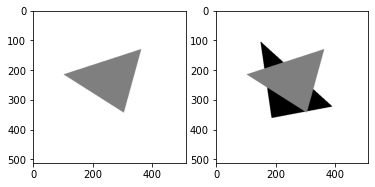

In [11]:
train_dataset =  LayerDataset(base_imgs,layer_imgs)

plt.subplot(121)
plt.imshow(train_dataset[0]['pixel_values'].permute(1,2,0)/ 2 + 1/2)

plt.subplot(122)
plt.imshow(train_dataset[0]['conditioning_pixel_values'].permute(1,2,0))

In [12]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)

### Create a subset of validation images

In [13]:
VALIDATION_SIZE=2
H=W=512

val_binaries = []
val_layers = []
val_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(VALIDATION_SIZE):
    img,_,_ = generate_triangle_sdf(H,W)
    img = 1- img
    
    #Mask (foreground layer)
    mask_img,_,_ = generate_triangle_sdf(H,W)
    mask_img = mask_img[:,:,0].astype(int)

    #Plain background layer
    bg_layer = np.ones([H,W])
    
    #Compositing full image
    masked_img = np.copy(img)
    masked_img[mask_img==1] = .5
    
    #Compositing layer map
    fg_layer = mask_img
    mid_layer = (1-img).squeeze()
    layer_bin = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)

    #add to lists
    val_binaries.append(layer_bin)
    val_layers.append((gray2rgb(1-fg_layer[...,np.newaxis]*.5),
                       gray2rgb(1-mid_layer[...,np.newaxis]),
                       gray2rgb(bg_layer[...,np.newaxis])))
    val_imgs.append(gray2rgb(masked_img))
    
#     if itr%200 == 0:
#         print(itr)

In [14]:
from PIL import Image

val_imgs_PIL = []
val_layers_PIL = []
for idx in range(len(val_imgs)):
    val_imgs_PIL.append(Image.fromarray(val_imgs[idx]))
    val_layers_PIL.append(Image.fromarray(val_layers[idx][0]))

args.validation_image = val_imgs_PIL
args.validation_prompt = [""]
args.num_validation_images = VALIDATION_SIZE

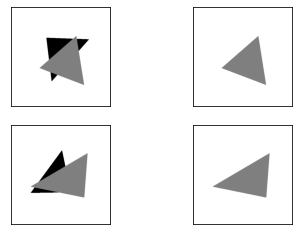

In [15]:
## Hard code some things for getting the first layer of each val_layers for now

plt.subplot(221)
plt.imshow(val_imgs_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(222)
plt.imshow(val_layers_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(223)
plt.imshow(val_imgs_PIL[1])
plt.xticks([]);plt.yticks([]);

plt.subplot(224)
plt.imshow(val_layers_PIL[1])
plt.xticks([]);plt.yticks([]);

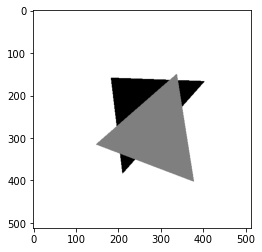

In [16]:
plt.imshow(conditioning_image_transforms(np.array(val_imgs_PIL[0])).permute(1,2,0))

## Implement the adapter models

In [17]:
import torch
import torch.nn as nn

## Network that takes 4 dimensional input and pushes it to 3 dimensions for the vae
class ContractNet(nn.Module):
    def __init__(self):
        super(ContractNet, self).__init__()
        self.conv = nn.Conv2d(4, 3, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

    

## Network that takes 3 dimensional input and pushes it to 4 dimensions for model out
class ExpandNet(nn.Module):
    def __init__(self):
        super(ExpandNet, self).__init__()
        self.conv = nn.Conv2d(3, 4, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [18]:
#Instantiate the two adapters and the pretrained model

# An adapter that takes in the original image (or a subset of layers)
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(1), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter
# adapter = MultiAdapter([RGB_adapter,mask_adapter])
adapter = RGB_adapter

#Instantiate the Convolutional layers
# contract_layer = ContractNet()
# expand_layer = ExpandNet()

#Pretrained stable diffusion model that we will try not to touch (may end up changing the final conv_out though.
#To be honest I am really hoping this works

model_name = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionAdapterPipeline.from_pretrained(model_name, torch_dtype=torch.float32).to("cuda")
pipe.safety_checker = None

vae = pipe.vae
unet = pipe.unet

noise_scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")

# also get the clip model because it matters probably....

#But looks like it may not work as just the model for training so we have to separate it into parts for training anyway

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [19]:
#Random point, what if I dont do anything about the masking etc, and just try and make a model that removes the top object in a scene, or like just tries to get the layer mappings?

## Train the model

### TODO: Write a validation loop

In [20]:
def log_validation(pipe, adapter, args, step=0,accelerator=None):
    print(f"step = {step}")

    # controlnet = accelerator.unwrap_model(controlnet)

    pipe.adapter = adapter
    # pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    # pipeline = pipeline.to(accelerator.device)
    # pipeline.set_progress_bar_config(disable=True)

#     if args.enable_xformers_memory_efficient_attention:
#         pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    if len(args.validation_image) == len(args.validation_prompt):
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt
    elif len(args.validation_image) == 1:
        validation_images = args.validation_image * len(args.validation_prompt)
        validation_prompts = args.validation_prompt
    elif len(args.validation_prompt) == 1:
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt * len(args.validation_image)
    else:
        raise ValueError(
            "number of `args.validation_image` and `args.validation_prompt` should be checked in `parse_args`"
        )

    image_logs = []

    for validation_prompt, validation_image in zip(validation_prompts, validation_images):
        # validation_image = Image.open(validation_image).convert("RGB")

        images = []

        for _ in range(args.num_validation_images):
            with torch.autocast("cuda"):
                image = pipe(
                    validation_prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]

            images.append(image)

        image_logs.append(
            {"validation_image": validation_image, "images": images, "validation_prompt": validation_prompt}
        )
        
    
    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                validation_image = log["validation_image"]

                formatted_images = []

                formatted_images.append(np.asarray(validation_image))

                for image in images:
                    formatted_images.append(np.asarray(image))

                formatted_images = np.stack(formatted_images)

                tracker.writer.add_images(validation_prompt, formatted_images, step, dataformats="NHWC")
        elif tracker.name == "wandb":
            formatted_images = []

            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                validation_image = log["validation_image"]

                formatted_images.append(wandb.Image(validation_image, caption="Controlnet conditioning"))

                for image in images:
                    image = wandb.Image(image, caption=validation_prompt)
                    formatted_images.append(image)

            tracker.log({"validation": formatted_images})
        else:
            logger.warn(f"image logging not implemented for {tracker.name}")

    return image_logs

# Here I need to make a set of images 
# Looks like top row, validation image *2, next validation image *2, bottom row is outputs

def save_image_logs(image_logs,step=0):
    plt.figure()
    plt.subplot(241)
    plt.imshow(image_logs[0]['validation_image'])
    plt.subplot(242)
    plt.imshow(image_logs[0]['validation_image'])
    plt.subplot(243)
    plt.imshow(image_logs[1]['validation_image'])
    plt.subplot(244)
    plt.imshow(image_logs[1]['validation_image'])

    plt.subplot(245)
    plt.imshow(image_logs[0]['images'][0])
    plt.subplot(246)
    plt.imshow(image_logs[0]['images'][1])
    plt.subplot(247)
    plt.imshow(image_logs[1]['images'][0])
    plt.subplot(248)
    plt.imshow(image_logs[1]['images'][1])

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

    plt.savefig(f'test_logs/epoch_{step}_val.png')

### Prepare the accelerator

In [21]:
from pathlib import Path
import logging
import os

args.output_dir = "test_logs/test_out"
args.logging_dir = "test_logs/test_logs"
args.tracker_project_name = "scratch cubic testing"#"cubic timestep sampling"

args.gradient_accumulation_steps=1
args.mixed_precision = None
args.report_to = "wandb"
args.push_to_hub = False

In [22]:
import wandb
import random
!wandb login "d9387a82bf250d82223965b50544c06bfa6bf8bd"

#Initialize the accelerator 
def init_accelerator():
    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
    )

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )


    logger = get_logger(__name__)
    logger.info(accelerator.state, main_process_only=False)
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

    if accelerator.is_main_process:
        tracker_config = dict(vars(args))

        # tensorboard cannot handle list types for config
        tracker_config.pop("validation_prompt")
        tracker_config.pop("validation_image")

        accelerator.init_trackers(args.tracker_project_name, config=tracker_config)
    return accelerator, logger

wandb: Appending key for api.wandb.ai to your netrc file: /n/home07/adamaraju/.netrc


In [23]:
# if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
#     # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
#     def save_model_hook(models, weights, output_dir):
#         i = len(weights) - 1

#         while len(weights) > 0:
#             weights.pop()
#             model = models[i]

#             sub_dir = "adapter"
#             model.save_pretrained(os.path.join(output_dir, sub_dir))

#             i -= 1

# #     def load_model_hook(models, input_dir):
# #         while len(models) > 0:
# #             # pop models so that they are not loaded again
# #             model = models.pop()

# #             # load diffusers style into model
# #             load_model = ControlNetModel.from_pretrained(input_dir, subfolder="controlnet")
# #             model.register_to_config(**load_model.config)

# #             model.load_state_dict(load_model.state_dict())
# #             del load_model

### Actual training loop

In [24]:
#Put adapter on GPU / prepare accelerator
vae.requires_grad_(False)
adapter = adapter.to("cuda")
# adapter = accelerator.unwrap_model(adapter)


#Set optimizer class
optimizer_class = torch.optim.AdamW

#Get parameters to optimize
params_to_optimize = adapter.parameters()
optimizer = optimizer_class(
    params_to_optimize,
    lr = args.lr
) 

#Get lr scheduler = 
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,# * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps,# * args.gradient_accumulation_steps,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)
# additional, try to figure out accelerator

# adapter, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
#     adapter, optimizer, train_dataloader, lr_scheduler)

In [25]:
# !pip install wandb

In [ ]:
## https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet.py
#Set number of max train steps?
# def training_loop():
#initialize the accelerator
accelerator, logger = init_accelerator()
adapter = accelerator.unwrap_model(adapter)
adapter, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    adapter, optimizer, train_dataloader, lr_scheduler)

args.max_train_steps = args.num_train_epochs * len(train_dataloader)

# Train!
total_batch_size = args.train_batch_size #* accelerator.num_processes * args.gradient_accumulation_steps


logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

initial_global_step = 0

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    # disable=not accelerator.is_local_main_process,
)

weight_dtype = torch.float32
image_logs = None
for epoch in range(first_epoch, args.num_train_epochs):
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(adapter):
            #### Convert images to latent space
            #network that goes from four to three dimensions
            # contract_in = contract_layer()
            latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype).to('cuda')).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            # print('Latents calculated')

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = (1 - (timesteps/ noise_scheduler.config.num_train_timesteps)**3) *  noise_scheduler.config.num_train_timesteps
            timesteps = timesteps.to(torch.int).clamp(0,noise_scheduler.config.num_train_timesteps-1).to(latents.device).long()
            # timesteps = timesteps.long()
            # print('Noise Generated')

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            prompt_embeds = pipe._encode_prompt(
                "",
                device="cuda",
                num_images_per_prompt = args.train_batch_size ,
                do_classifier_free_guidance=args.do_classifier_free_guidance,
                negative_prompt=None,
                prompt_embeds=None,
                negative_prompt_embeds=None,
            )
            # print('Prompt Embeddings Generated')

            # Denoising loop
            adapter_input = batch["conditioning_pixel_values"].to(dtype=weight_dtype).to('cuda')
            adapter_state = adapter(adapter_input)
            for k, v in enumerate(adapter_state):
                adapter_state[k] = v * args.adapter_conditioning_scale
            if args.num_images_per_prompt > 1:
                for k, v in enumerate(adapter_state):
                    adapter_state[k] = v.repeat(args.num_images_per_prompt, 1, 1, 1)
            if args.do_classifier_free_guidance:
                for k, v in enumerate(adapter_state):
                    adapter_state[k] = torch.cat([v] * 2, dim=0)
            # print('Adapter values Generated')


            ## expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([noisy_latents] * 2) if args.do_classifier_free_guidance else noisy_latents

            # predict the noise residual
            noise_pred = unet(
                    latent_model_input,
                    timesteps,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=None,
                    down_block_additional_residuals=[state.clone() for state in adapter_state],
            ).sample

            # print('Prediction complete')
            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
            # print('loss computed')
            # loss.backward()
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad(set_to_none=args.set_grads_to_none)


        #Stuff here for accelerator
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            if accelerator.is_main_process:
                #Code for saving checkpoints
                pass


        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
    if epoch % 2 == 0:
        val_out = log_validation(pipe, adapter, args, accelerator = accelerator)
        save_image_logs(val_out,step=epoch)
    if global_step >= args.max_train_steps:
        break

accelerator.end_training()

06/24/2023 14:03:51 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

06/24/2023 14:03:51 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

06/24/2023 14:03:52 - ERROR - wandb.jupyter - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aneeldamaraju. Use `wandb login --relogin` to force relogin


06/24/2023 14:04:03 - INFO - __main__ - ***** Running training *****
06/24/2023 14:04:03 - INFO - __main__ -   Num examples = 1000
06/24/2023 14:04:03 - INFO - __main__ -   Num batches each epoch = 250
06/24/2023 14:04:03 - INFO - __main__ -   Num Epochs = 10
06/24/2023 14:04:03 - INFO - __main__ -   Instantaneous batch size per device = 4
06/24/2023 14:04:03 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 4
06/24/2023 14:04:03 - INFO - __main__ -   Gradient Accumulation steps = 1
06/24/2023 14:04:03 - INFO - __main__ -   Total optimization steps = 2500


Steps:   0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
# import os
# from accelerate.utils import write_basic_config

# write_basic_config()  # Write a config file
# os._exit(00)  # Restart the notebook

In [ ]:
training_loop()

In [ ]:
# from accelerate import notebook_launcher

# notebook_launcher(training_loop, num_processes=2)

### wandbstuff

In [ ]:
!wandb login
!d9387a82bf250d82223965b50544c06bfa6bf8bd

In [ ]:
import wandb
import random
!wandb login "d9387a82bf250d82223965b50544c06bfa6bf8bd"

In [ ]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

In [ ]:
from pathlib import Path
args.output_dir = "test_logs/test_out"
args.logging_dir = "test_logs/test_logs"

args.gradient_accumulation_steps=1
args.mixed_precision = None
args.report_to = "wandb"
args.push_to_hub = False

In [ ]:
logging_dir = Path(args.output_dir, args.logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)



In [ ]:
accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

In [ ]:
import logging
import os

In [ ]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [ ]:
logger = get_logger(__name__)
logger.info(accelerator.state, main_process_only=False)

In [ ]:
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()
    
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

    if args.push_to_hub:
        repo_id = create_repo(
            repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
        ).repo_id

In [ ]:
adapter = accelerator.unwrap_model(adapter)
adapter, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    adapter, optimizer, train_dataloader, lr_scheduler
)

In [ ]:
args.tracker_project_name = "double gpu test"
if accelerator.is_main_process:
    tracker_config = dict(vars(args))

    # tensorboard cannot handle list types for config
    tracker_config.pop("validation_prompt")
    tracker_config.pop("validation_image")

    accelerator.init_trackers(args.tracker_project_name, config=tracker_config)

In [ ]:
accelerator.trackers

In [ ]:
tracker_config